# Comparing machine learning approaches to predict SEEG accuracy

[![DOI](https://zenodo.org/badge/99125443.svg)](https://zenodo.org/badge/latestdoi/99125443)

Stereoencephalography (SEEG) is a technique used in drug-resistant epilepsy patients that may be a candidate for surgical resection of the epileptogenic zone. Multiple electrodes are placed using a so-called "frame based" stereotactic approach, in our case using the [Leksell frame](https://www.elekta.com/neurosurgery/leksell-stereotactic-system/). In our previous paper "[Methodology, outcome, safety and in vivo accuracy in traditional frame-based stereoelectroencephalography](https://www.ncbi.nlm.nih.gov/pubmed/28676892)" by Van der Loo et al (2017) we reported on SEEG electrode implantation accuracy in a cohort of 71 patients who were operated between September 2008 and April 2016, in whom a total of 902 electrodes were implanted. Data for in vivo application accuracy analysis were available for 866 electrodes.

The goal of the current project is to use a public version of this dataset (without any personal identifiers) to predict electrode implantation accuracy by using and comparing different machine learning approaches. 

[Pieter Kubben](http://dign.eu), MD, PhD<br/>
neurosurgeon @ [Maastricht University Medical Center](https://www.mumc.nl/en), The Netherlands

For any questions you can reach me by [email](mailto:p.kubben@mumc.nl) or on [Twitter](http://twitter.com/DigNeurosurgeon).

## Data description

The public dataset contains these variables:

- *PatientPosition*: patient position during surgery (nominal: supine, prone)
- *Contacts*: nr of contacts of electrode implanted (ordinal: 5, 8, 10, 12, 15, 18)
- *ElectrodeType*: describes trajectory type (nominal: oblique, orthogonal). Oblique refers to implantation using the Leksell arc, and orthogonal using a dedicated L-piece mounted on the frame (mostly implants in temporal lobe) when arc angles become too high (approx > 155&deg;) or too low (approx < 25&deg;)
- *PlanningX*: planned Cartesian X coord of target (numeric, in mm)
- *PlanningY*: planned Cartesian Y coord of target (numeric, in mm)
- *PlanningZ*: planned Cartesian Z coord of target (numeric, in mm)
- *PlanningRing*: planned ring coord, the trajectory direction in sagittal plane (numeric, in degrees); defines entry
- *PlanningArc*: planned arc coord (trajectory direction in coronal plane (numeric, in degrees); defines entry
- *DuraTipDistancePlanned*: distance from dura mater (outer sheet covering the brain surface) to target (numeric, in mm)
- *EntryX*: real Cartesian X coord of entry point (numeric, in mm)
- *EntryY*: real Cartesian Y coord of entry point (numeric, in mm)
- *EntryZ*: real Cartesian Z coord of entry point (numeric, in mm)
- *TipX*: real Cartesian X coord of target point (numeric, in mm)
- *TipY*: real Cartesian Y coord of target point (numeric, in mm)
- *TipZ*: real Cartesian Z coord of target point (numeric, in mm)
- *SkinSkullDistance*: distance between skin surfacce and skull surface (numeric, in mm)
- *SkullThickness*: skull thickness (numeric, in mm)
- *SkullAngle*: insertion angle of electrode relative to skull (numeric, in degrees)
- *ScrewLength*: length of bone screw used to guide and fixate electrode (ordinal: 20, 25, 30, 35 mm)

The electrodes are the [Microdeep depth electrodes](http://www.diximedical.com/en/microdeep-depth-electrode) by DIXI Medical.

To the limited extent possible in this case I tried to make these [FAIR data](https://www.nature.com/articles/sdata201618) and adhere to [FAIR guiding principles](https://www.nature.com/articles/sdata201618#bx2). In practice this meant I introduced the topic, described my data and created a [DOI](https://zenodo.org/badge/latestdoi/99125443).

Now let's get started.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline
import warnings; warnings.simplefilter('ignore')
%xmode plain; # shorter error messages

# global setting whether to save figures or not
# will save as 300 dpi PNG - all filenames start with "fig_"
save_figures = False

In [2]:
# load data
electrodes = pd.read_csv('electrodes_public.csv')

# find missing values
nan_rows = sum([True for idx,row in electrodes.iterrows() if any(row.isnull())])
print('Nr of rows with missing values:', nan_rows)

Nr of rows with missing values: 823


We will calculate target point localization error (TPLE) using the [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) and remove the entry data as we won't be using them (still wanted to share them in dataset though).

In [3]:
# calculate TPLE and remove entry data from dataframe
electrodes['TPLE'] = np.sqrt(np.square(electrodes['TipX'] - electrodes['PlanningX']) + 
                              np.square(electrodes['TipY'] - electrodes['PlanningY']) + 
                              np.square(electrodes['TipZ'] - electrodes['PlanningZ'])
                             ).round(1)
electrodes.drop(['EntryX', 'EntryY', 'EntryZ'], axis = 1, inplace = True)
electrodes.head()

,PatientPosition,Contacts,ElectrodeType,PlanningX,PlanningY,PlanningZ,PlanningRing,PlanningArc,DuraTipDistancePlanned,TipX,TipY,TipZ,SkinSkullDistance,SkullThickness,SkullAngle,ScrewLength,TPLE
0,Supine,18.0,Oblique,125.8,106.5,135.5,154.6,90.2,86.6,126.4,106.8,135.2,7.0,9.7,70.3,25.0,0.7
1,Supine,18.0,Oblique,130.6,131.0,136.4,155.4,96.6,105.9,134.7,132.9,136.0,9.4,7.4,63.8,30.0,4.5
2,Supine,10.0,Oblique,139.1,104.9,124.0,131.1,146.0,35.2,139.1,108.3,124.4,9.8,5.5,66.4,30.0,3.4
3,Supine,10.0,Oblique,137.7,112.2,115.0,96.2,137.1,35.9,136.4,115.2,115.0,8.4,6.5,66.3,25.0,3.3
4,Supine,12.0,Oblique,126.0,76.0,124.1,159.1,156.3,39.5,124.6,75.8,126.8,7.4,4.6,84.7,25.0,3.0


In [4]:
#electrodes

Now we will remove large outliers (difference between planned and real coord) in the Z-axis as electrode insertion length (depth) is influenced also by other factors (calculations regarding depth which could lead to either too superficial or too deep, but also possible malfixation of the screw cap which may cause loosening of the electrode and hence a more superficial position.. it won't migrate into the depth spontaneously). These are very limited numbers and would too much influence further analysis.

In [5]:
# check for outliers in Z axis
large_depth_error = electrodes[np.abs(electrodes['PlanningZ'] - electrodes['TipZ']) > 10]
print('Outliers in Z axis (> 10mm):\n\n', large_depth_error['TPLE'])

# remove outliers
electrodes.drop(large_depth_error.index, inplace = True)
print('\nNew dataframe shape:', electrodes.shape) # removed 6 rows

Outliers in Z axis (> 10mm):

 446    14.8
462    14.5
463    11.2
508    45.8
612    14.2
632    20.0
Name: TPLE, dtype: float64

New dataframe shape: (860, 17)


We need to structure our data properly for further analysis and convert the categorical variables (nominal, ordinal) to the `category` type.

In [6]:
# convert categorical columns to "category" dtype
catcols = ['PatientPosition', 'Contacts', 'ElectrodeType', 'ScrewLength']
for cat in catcols:
    electrodes[cat] = electrodes[cat].astype('category')

# confirm correct types for all columns now
electrodes.dtypes

PatientPosition           category
Contacts                  category
ElectrodeType             category
PlanningX                  float64
PlanningY                  float64
PlanningZ                  float64
PlanningRing               float64
PlanningArc                float64
DuraTipDistancePlanned     float64
TipX                       float64
TipY                       float64
TipZ                       float64
SkinSkullDistance          float64
SkullThickness             float64
SkullAngle                 float64
ScrewLength               category
TPLE                       float64
dtype: object

Let's get a short description of our TPLE data.

In [7]:
# get summary data on TPLE
tple = electrodes['TPLE']
tple.describe().round(1)

count    860.0
mean       3.4
std        2.3
min        0.2
25%        2.0
50%        2.9
75%        4.1
max       19.8
Name: TPLE, dtype: float64

We now have data in the right format, but for classification we need to bin the *continuous* outcome variables EPLE and TPLE into categories. Alternatively we could approach this as a regression problem, but given the relative limited amount of data classification should lead to a better prediction model that is still relevant for potential clinical use.

Let's create a new variable `TPLE category` for this purpose.

In [8]:
outliar_electrodes = electrodes.loc[electrodes['TPLE'] < 10]
# outliar_electrodes = outliar_electrodes.drop(['TipX', 'TipY', 'TipZ'], axis=1)
rep_pat=[]
rep_ele=[]
for i in range(0, len(outliar_electrodes['PatientPosition'])):
    try :
        if outliar_electrodes['PatientPosition'][i] == 'Prone': 
            rep_pat.append(1)
        elif outliar_electrodes['PatientPosition'][i] == 'Supine':
            rep_pat.append(2)
    except:
        rep_pat.append(0)
    
for i in range(0, len(outliar_electrodes['ElectrodeType'])):
    try:
        if outliar_electrodes['ElectrodeType'][i] == 'Oblique': 
            rep_ele.append(1)
        elif outliar_electrodes['ElectrodeType'][i] == 'Orthogonal':
            rep_ele.append(2)
    except:
        rep_ele.append(0)

In [9]:
from sklearn.model_selection import train_test_split
from collections import Counter
drop_target = outliar_electrodes.drop(['PatientPosition', 'ElectrodeType', 'ScrewLength'], axis=1)
drop_target = drop_target.assign(PatientPosition=pd.Series(rep_pat).values)
drop_target = drop_target.assign(ElectrodeType=pd.Series(rep_ele).values)

In [10]:
# ave_ring = np.mean(electrodes['PlanningRing'])
# ave_arc = np.mean(electrodes['PlanningArc'])
# ave_dur = np.mean(electrodes['DuraTipDistancePlanned'])

In [11]:
# rep_ring=drop_target['PlanningRing'].fillna(ave_ring)
# rep_arc=drop_target['PlanningArc'].fillna(ave_arc)
# rep_dur=drop_target['DuraTipDistancePlanned'].fillna(ave_dur)
# drop_target = drop_target.drop(['PlanningRing', 'PlanningArc', 'DuraTipDistancePlanned'], axis=1)
# drop_target = drop_target.assign(PlanningRing=pd.Series(rep_ring).values)
# drop_target = drop_target.assign(PlanningArc=pd.Series(rep_arc).values)
# drop_target = drop_target.assign(DuraTipDistancePlanned=pd.Series(rep_dur).values)

In [12]:
# drop_target.isnull().any()
rep_con = drop_target['Contacts'].fillna(8.0)
drop_target = drop_target.drop(['Contacts'], axis=1)
drop_target = drop_target.assign(Contacts=pd.Series(rep_con).values)

In [13]:
drop_target_1 = drop_target[drop_target.ElectrodeType == 1] #PatientPosition
drop_target_2 = drop_target[drop_target.ElectrodeType == 2] #PatientPosition
# drop_target_1_class = drop_target_1['TPLE']
# drop_target_2_class = drop_target_2['TPLE']
# drop_target_1 = drop_target_1.drop(['TPLE'], axis=1)
# drop_target_2 = drop_target_2.drop(['TPLE'], axis=1)

In [14]:
drop_target_3 = drop_target[drop_target.PatientPosition == 1] #PatientPosition
drop_target_4 = drop_target[drop_target.PatientPosition == 2] #PatientPosition
# drop_target_3_class = drop_target_3['TPLE']
# drop_target_4_class = drop_target_4['TPLE']
# drop_target_3 = drop_target_3.drop(['TPLE'], axis=1)
# drop_target_4 = drop_target_4.drop(['TPLE'], axis=1)

In [15]:
df_all=drop_target[np.invert(pd.isnull(drop_target).any(axis=1))]
df_all_target = df_all['TPLE']
df_all_target_X=df_all['TipX']#['TPLE'] TipX
df_all_target_Y=df_all['TipY']#['TPLE'] TipY
df_all_target_Z=df_all['TipZ']#['TPLE'] TipZ
df_all = df_all.drop(['TipX', 'TipY', 'TipZ', 'TPLE'], axis=1) #'PlanningX', 'PlanningY', 'PlanningZ'

df_sob=drop_target_4.loc[drop_target_4['ElectrodeType'] == 1][np.invert(pd.isnull(drop_target_4).any(axis=1))]
df_sob_target = df_sob['TPLE']
df_sob = df_sob.drop(['TPLE'], axis=1)

df_pob=drop_target_3.loc[drop_target_3['ElectrodeType'] == 1][np.invert(pd.isnull(drop_target_3).any(axis=1))]
df_pob_target = df_pob['TPLE']
df_pob = df_pob.drop(['TPLE'], axis=1)

df_s=drop_target_4[np.invert(pd.isnull(drop_target_4).any(axis=1))]
df_s_target = df_s['TPLE']
df_s = df_s.drop(['TPLE'], axis=1)

df_p=drop_target_3[np.invert(pd.isnull(drop_target_3).any(axis=1))]
df_p_target = df_p['TPLE']
df_p = df_p.drop(['TPLE'], axis=1)

df_ob=drop_target_1[np.invert(pd.isnull(drop_target_1).any(axis=1))]
df_ob_target = df_ob['TPLE']
df_ob = df_ob.drop(['TPLE'], axis=1)

df_or = drop_target_2.drop(['PlanningRing', 'PlanningArc', 'DuraTipDistancePlanned'], axis=1)
df_or=df_or[np.invert(pd.isnull(df_or).any(axis=1))]
df_or_target = df_or['TPLE']
df_or = df_or.drop(['TPLE'], axis=1)

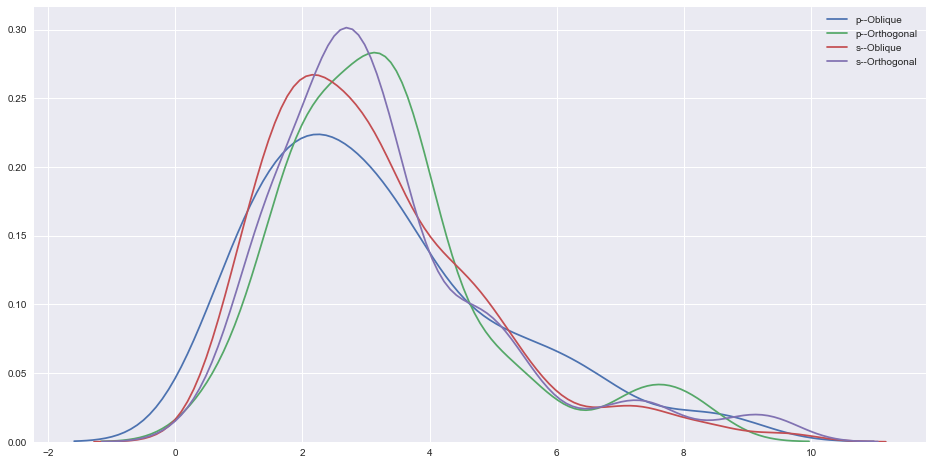

In [16]:
plt.figure(figsize=[16, 8])
# sns.kdeplot(drop_target['TPLE'], label='all')
sns.kdeplot(drop_target_3[drop_target_3['ElectrodeType']==1]['TPLE'], label='p--Oblique')
sns.kdeplot(drop_target_3[drop_target_3['ElectrodeType']==2]['TPLE'], label='p--Orthogonal')
sns.kdeplot(drop_target_4[drop_target_4['ElectrodeType']==1]['TPLE'], label='s--Oblique')
sns.kdeplot(drop_target_4[drop_target_4['ElectrodeType']==2]['TPLE'], label='s--Orthogonal')

In [ ]:
# Separate datasets into train and test

In [91]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
train = df_all
# target = df_all_target
target = np.transpose([df_all_target_X,df_all_target_Y,df_all_target_Z]) #df_all_target
# sld_train=RobustScaler(range(0,10)).fit_transform(train)
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.2, random_state=6)
len(target)

523

In [88]:
# KNN
from sklearn import neighbors
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [ ]:
# Fit regression model
n_neighbors = 12
err = []
for i, weights in enumerate(['distance']): #'uniform',
    knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
    y_pred = knn.fit(X_train, y_train).predict(X_test)
    
    for i in range(0, len(y_test)):
        print(list(y_test)[i], list(y_pred)[i], list(y_test)[i]-list(y_pred)[i])
        err.append(list(y_test)[i]-list(y_pred)[i])
    #print('MAE', r2_score(y_test, y_pred)) #mean_absolute_error
    print('RSS', mean_squared_error(y_test, y_pred)) #mean_absolute_error mean_squared_error
np.sqrt(mean_squared_error(y_test, y_pred))

In [ ]:
# import ipyvolume as ipv
# import numpy as np
# x=[]
# y=[]
# z=[]
# x = np.append(np.array(X_test['PlanningX']), y_pred[:, 0]) #y_pred
# y = np.append(np.array(X_test['PlanningY']), y_pred[:, 1])
# z = np.append(np.array(X_test['PlanningZ']), y_pred[:, 2])

# selected = list(range(0,105))

# quiver=ipv.quickscatter(x, y, z, size=1, size_selected=1, selected=selected, color_selected='green', marker="sphere")


# ipv.show()

In [92]:
from sklearn.neural_network import MLPRegressor
nn = MLPRegressor(activation='identity', solver='lbfgs', max_iter=1000, \
                  random_state=6, hidden_layer_sizes=20)
y_pred = nn.fit(X_train, y_train).predict(X_test)
for i in range(0, len(y_test)):
        print(list(y_test)[i], list(y_pred)[i], list(y_test)[i]-list(y_pred)[i])
print('RSS', mean_squared_error(y_test, y_pred))
np.sqrt(mean_squared_error(y_test, y_pred))

[  65.9   92.3  101. ] [  65.18542223   94.00228438  100.98640069] [ 0.71457777 -1.70228438  0.01359931]
[ 126.7  119.7  137.6] [ 126.74759754  116.90751488  138.78144961] [-0.04759754  2.79248512 -1.18144961]
[ 70.1  65.4  69. ] [ 71.26679577  65.98243686  68.09792132] [-1.16679577 -0.58243686  0.90207868]
[  75.9   88.3  109.6] [  75.00513912   87.73140946  109.97785381] [ 0.89486088  0.56859054 -0.37785381]
[ 135.1   96.1  106.6] [ 135.0804278    96.38213228  106.40703298] [ 0.0195722  -0.28213228  0.19296702]
[  88.   130.7  109.5] [  88.6705247   130.87252201  110.36192748] [-0.6705247  -0.17252201 -0.86192748]
[ 107.9  173.9  116.7] [ 108.25539376  172.18827783  117.11867619] [-0.35539376  1.71172217 -0.41867619]
[  62.1   96.5  106.5] [  59.79010419   95.81141758  106.42178936] [ 2.30989581  0.68858242  0.07821064]
[ 71.   64.   60.3] [ 70.98889518  62.69073454  59.90236765] [ 0.01110482  1.30926546  0.39763235]
[ 135.7  110.7   89.8] [ 136.42229598  110.83928461   88.8563254 ] 

1.736520801172895

In [93]:
temp=np.transpose([list(X_test['PlanningX']),list(X_test['PlanningY']),list(X_test['PlanningZ'])])
com = pd.DataFrame.from_records(temp)
com.columns = ['planX', 'planY', 'planZ']
com = com.assign(TipX=pd.Series(y_test[:, 0]).values)
com = com.assign(TipY=pd.Series(y_test[:, 1]).values)
com = com.assign(TipZ=pd.Series(y_test[:, 2]).values)
com = com.assign(predX=pd.Series(y_pred[:, 0]).values)
com = com.assign(predY=pd.Series(y_pred[:, 1]).values)
com = com.assign(predZ=pd.Series(y_pred[:, 2]).values)

In [96]:
pred_point = np.sqrt(np.square(com['predX'] - com['planX']) + 
                              np.square(com['predY'] - com['planY']) + 
                              np.square(com['predZ'] - com['planZ'])
                             ).round(1)
tip_point = np.sqrt(np.square(com['TipX'] - com['planX']) + 
                              np.square(com['TipY'] - com['planY']) + 
                              np.square(com['TipZ'] - com['planZ'])
                             ).round(1)
com = com.assign(pred_point=pd.Series(pred_point).values)
com = com.assign(tip_point=pd.Series(tip_point).values)
print('RSS', mean_squared_error(tip_point, pred_point))
com

RSS 4.53685714286


,planX,planY,planZ,TipX,TipY,TipZ,predX,predY,predZ,pred_point,tip_point
0,66.1,95.2,100.4,65.9,92.3,101.0,65.185422,94.002284,100.986401,1.6,3.0
1,127.7,116.8,136.7,126.7,119.7,137.6,126.747598,116.907515,138.781450,2.3,3.2
2,71.2,66.6,67.1,70.1,65.4,69.0,71.266796,65.982437,68.097921,1.2,2.5
3,75.1,88.6,109.2,75.9,88.3,109.6,75.005139,87.731409,109.977854,1.2,0.9
4,134.6,95.0,105.8,135.1,96.1,106.6,135.080428,96.382132,106.407033,1.6,1.4
5,89.2,131.9,109.7,88.0,130.7,109.5,88.670525,130.872522,110.361927,1.3,1.7
6,110.1,171.3,115.2,107.9,173.9,116.7,108.255394,172.188278,117.118676,2.8,3.7
7,61.1,97.0,105.2,62.1,96.5,106.5,59.790104,95.811418,106.421789,2.1,1.7
8,70.4,62.9,58.8,71.0,64.0,60.3,70.988895,62.690735,59.902368,1.3,2.0
9,135.6,109.8,88.6,135.7,110.7,89.8,136.422296,110.839285,88.856325,1.3,1.5


523

In [ ]:
# Isotonic Regression
from sklearn.linear_model import LinearRegression, ARDRegression

lr = LinearRegression()
ard = ARDRegression()
y_pred = ard.fit(X_train, y_train).predict(X_test)
# for i in range(0, len(y_test)):
#         print(list(y_test)[i], list(y_pred)[i], list(y_test)[i]-list(y_pred)[i])
print('RSS', mean_squared_error(y_test, y_pred))
np.sqrt(mean_squared_error(y_test, y_pred))

In [ ]:
from sklearn.kernel_ridge import KernelRidge

kr = KernelRidge(alpha=1.0)
y_pred = kr.fit(X_train, y_train).predict(X_test)
print('RSS', mean_squared_error(y_test, y_pred))
np.sqrt(mean_squared_error(y_test, y_pred))

In [ ]:
# from sklearn.svm import SVR

# svr = SVR(C=100, epsilon=0.1)
# y_pred = svr.fit(X_train, y_train).predict(X_test)
# for i in range(0, len(y_test)):
#        print(list(y_test)[i], list(y_pred)[i], list(y_test)[i]-list(y_pred)[i])
# print('RSS', mean_squared_error(y_test, y_pred))
# np.sqrt(mean_squared_error(y_test, y_pred))

In [ ]:
from sklearn.tree import ExtraTreeRegressor
from collections import Counter
# Build a forest and compute the feature importances
forest = ExtraTreeRegressor()

forest.fit(train, target)
importances = forest.feature_importances_
# std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(train.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], train.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(train.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(train.shape[1]), indices)
plt.xlim([-1, train.shape[1]])
plt.show()

In [ ]:
# create different possible cuts to create categories (and experiment with them)
tple_max = tple.max().round()
electrodes_3cat = pd.cut(tple, bins = [0, 2.5, 5, tple_max], labels = ['0 - 2.5', '2.5 - 5', '> 5'])
electrodes_4cat = pd.cut(tple, bins = [0, 2, 4, 6, tple_max], labels = ['0 - 2', '2 - 4', '4 - 6', '> 6'])
electrodes_4quant = pd.cut(tple, bins = [0, tple.quantile(.25), tple.median(), tple.quantile(.75), tple_max], labels = ['0 - 2', '2 - 3', '3 - 4', '> 4'])
electrodes_5cat = pd.cut(tple, bins = [0, 1, 2, 5, 10, tple_max], labels = ['0 - 1', '1 - 2', '2 - 5', '5 - 10', '> 10'])
electrodes_7cat = pd.cut(tple, bins = [0, 1, 2, 4, 6, 8, 10, tple_max], labels = ['0 - 1', '1 - 2', '2 - 4', '4 - 6', '6 - 8', '8 - 10', '> 10'])

# apply cut to create TPLE category column
#electrodes['TPLE category'] = electrodes_5cat
electrodes['TPLE category'] = electrodes_3cat
nr_of_y_categories = len(electrodes['TPLE category'].unique()) # needed for confusion matrix and keras MLP

# check correct conversion with first 15 rows
electrodes[['TPLE', 'TPLE category']].head(15).T

In [ ]:
# count nr of items in each category
electrodes[['TPLE', 'TPLE category']].groupby('TPLE category').count().T

In [ ]:
plt.figure(figsize=[16, 8])
sns.kdeplot(electrodes[electrodes['PatientPosition']=='Supine']['TPLE'], label='Supine')
sns.kdeplot(electrodes[electrodes['PatientPosition']=='Prone']['TPLE'], label='Prone')

In [ ]:
electrodes[electrodes['PatientPosition']=='Supine']['TPLE'].describe().round(2)

In [ ]:
electrodes[electrodes['PatientPosition']=='Prone']['TPLE'].describe().round(2)e

In [ ]:
from scipy import stats
stats.ttest_ind(electrodes[electrodes['PatientPosition']=='Supine']['TPLE'],
                electrodes[electrodes['PatientPosition']=='Prone']['TPLE'])

In [ ]:
plt.figure(figsize=[16, 8])
sns.kdeplot(electrodes[electrodes['ElectrodeType']=='Oblique']['TPLE'], label='Oblique')
sns.kdeplot(electrodes[electrodes['ElectrodeType']=='Orthogonal']['TPLE'], label='Orthogonal')

In [ ]:
plt.figure(figsize=[16, 8])
for i in contacts[:-1]:
    sns.kdeplot(electrodes[electrodes['Contacts']==i]['TPLE'])  

In [ ]:
sorted(electrodes['ElectrodeType'].unique())

In [ ]:
# Try regression

In [ ]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X_train, y_train)
print(metrics.classification_report(y_test, clf.predict(X_test)))
print('Accuracy: {}'.format(round(clf.score(X_test, y_test),2)))

In [ ]:
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, Imputer, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold
elec_features = electrodes.drop(['TPLE'], axis = 1)

# encode categorical features (no one hot encoding to avoid creating too much features)
for cat in catcols:
    elec_features[cat] = LabelEncoder().fit_transform(elec_features[cat])

X = elec_features # to start with
# deal with missing values the sklearn way (and do not impute if not needed to)
X = Imputer(strategy = 'most_frequent').fit_transform(X)

In [ ]:
y = electrodes['TPLE']

In [ ]:
# split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 33)

In [ ]:
from sklearn import linear_model
lm = linear_model.LinearRegression()
model = lm.fit(X_train,y_train)

In [ ]:
predictions = lm.predict(X_train)
#print(predictions)

In [ ]:
lm.score(X,y)

In [ ]:
lm.coef_

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_train, predictions)

In [ ]:
from sklearn.metrics import r2_score
r2_score(y_train, predictions)  

So we have a lof of electrodes in the 2-5mm TPLE category, which is explained well with an interquartile range of 2.0 - 4.1. Let's create some plots to learn more about our data.

## Visualization
Let's first get an impression of variable distributions.

In [ ]:
# plot TPLE distribution
tple.plot(kind = 'density', figsize = (15,5), title = 'TPLE density plot');
plt.xlim(0,10);
if save_figures:
    plt.savefig('fig_tple_density_plot.png', dpi = 300)

In [ ]:
# plot variable distributions (density)
params = {'subplots': True, 'layout': (3,4), 'sharex': False, 'figsize': (16, 12)}
elec_visual = electrodes.drop(['TPLE'], axis = 1)
elec_visual.plot(kind='density', **params);
if save_figures:
    plt.savefig('fig_variables_density_plot.png', dpi = 300)

In [ ]:
# alternatively, make a box plot
elec_visual.plot(kind='box', sharey = False, **params);
if save_figures:
    plt.savefig('fig_variables_boxplot.png', dpi = 300)

Now we have a visual impression of how variables are distributed. As we want to develop a model to predict TPLE category, it would be helpful to see to what extent variable distribution differs per TPLE category.

In [ ]:
# first relate numeric variables to TPLE category
numcols = list(electrodes.columns[electrodes.dtypes == float].drop('TPLE'))
fig, axes = plt.subplots(4,3, figsize = (15,20))
fig.subplots_adjust(hspace=.5)
electrodes.boxplot(column = numcols, by = 'TPLE category', ax = axes);
if save_figures:
    plt.savefig('fig_tplecompare_boxplot.png', dpi = 300)

In contrast to numerical variables in which we can plot categories against actual feature values, in categorical columns we can "only" plot categories against the number of items in each category. This is what we will do next.
> Note that these are absolute counts, and no ratios (e.g. supine position is used most and this reflects also below). So the point is to inspect the graphs for any remarkable ratio differences between categories and not simply look at the highest bars...

In [ ]:
# show absolute TPLE count per category 
elec_count = 'Electrode count'
for cat in catcols:
    cat_count = electrodes[[cat, 'TPLE','TPLE category']].groupby([cat,'TPLE category']).count()
    cat_count.rename_axis({'TPLE': elec_count}, axis = 'columns', inplace = True)
    sns.factorplot(x = cat, y = elec_count, data = cat_count.reset_index(), kind = 'bar', hue = 'TPLE category',
                   size = 5, aspect = 3);
    if save_figures:
        plt.savefig('fig_tplecompare_cat_{}.png'.format(cat), dpi = 300)

Now, how do they correlate with each other? To be able to get correlations we first have to deal with missing data. We will create a temporary soluting here for visualisation and use another (for that purpose recommended) approach for predictive modelling.

In [ ]:
# copy dataframe to temporary frame in which we'll impute missing values
elec_pairplot = electrodes

# create a utility function to check if we (still) have missing values present in our data
def print_missing(dataframe):
    '''checks which columns contain missing values and returns count'''
    df_na = dataframe.columns[electrodes.isnull().any()]
    
    if len(df_na) > 0:
        print('Missing data present in {} columns: \n'.format(len(df_na)))
        for c in df_na:
            print('- {} ({})'.format(c, dataframe[c].isnull().sum()))
    else:
        print('No missing data found! :-)')
        
print_missing(elec_pairplot)

In [ ]:
# use median values for numeric columns
for missing in ['PlanningRing', 'PlanningArc', 'DuraTipDistancePlanned']:
    elec_pairplot[missing] = elec_pairplot[missing].fillna(elec_pairplot[missing].median())

# use most frequent value for categorical columns
for missing in ['Contacts', 'ScrewLength']:
    most_frequent_value = elec_pairplot[missing].value_counts().index[0]
    print('Most frequent value in category "{}": {}'.format(missing, most_frequent_value))
    elec_pairplot[missing] = elec_pairplot[missing].fillna(most_frequent_value)

print_missing(elec_pairplot)

From practical experience I can confirm that we do use 18 contact points frequently often and it makes sense to use those here (only 56 missing... more advanced may be to correlate with other variables and decide then). Regarding screw length, 25mm is used by far the most, so even despite the fact that most values are missing (534 / 860) I still kept them in (in the original paper I referred to, increasing screw length seems to correspond with increasing TPLE).

Now let's look at some correlations.

In [ ]:
# pairplot to correlate variable distributions per category.. busy plot
sns.pairplot(elec_pairplot[['PatientPosition', 'Contacts', 'ElectrodeType', 'DuraTipDistancePlanned', 
                            'SkinSkullDistance', 'SkullThickness', 'SkullAngle', 'ScrewLength', 'TPLE category']], 
             hue = 'TPLE category');
if save_figures:
    plt.savefig('fig_electrodes_corr_pairplot.png', dpi = 300)

Those are not exactly easily separable clusters... looks bad for further predictive modelling.... :-(

Alternatively we will use Peason's correlations to create a "heatmap". To include categorical variables we need to "one hot encode" them first (using `pd.get_dummies()`).

In [ ]:
plt.figure(figsize = (15,12));
electrodes_dummies = pd.get_dummies(electrodes.drop(['TPLE category'], axis = 1))

# correlations for continuous variables only
# sns.heatmap(electrodes.corr(), square = True, annot = True, linewidths = .5, cmap = 'RdBu_r');

# correlations including categorical variables
sns.heatmap(electrodes_dummies.corr(), square = True, annot = False, cmap = 'RdBu_r');

if save_figures:
    plt.tight_layout() # needed to prevent cutting X-axis labels
    plt.savefig('fig_electrodes_corr_heatmap.png', dpi = 300)

## TPLE classification

We will now use several machine learning classification approaches (manual, auto ML and a quick glance at deep learning) to predict TPLE category. I tried several feature selection and dimensionality reduction approaches that I left in place as comments as they did not contribute to better results. 

### Manual approach

In [ ]:
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, Imputer, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold
elec_features = electrodes.drop(['TPLE', 'TPLE category'], axis = 1)

# encode categorical features (no one hot encoding to avoid creating too much features)
for cat in catcols:
    elec_features[cat] = LabelEncoder().fit_transform(elec_features[cat])

X = elec_features # to start with
# deal with missing values the sklearn way (and do not impute if not needed to)
X = Imputer(strategy = 'most_frequent').fit_transform(X)

# feature selection - none of these actually improved accuracy (not tried for all other outcomes)
# X = elec_features[['ScrewLength', 'PatientPosition', 'ElectrodeType', 'Contacts', 'SkullAngle']] 
# X = elec_features['SkullAngle'][:, np.newaxis]
# X = MinMaxScaler().fit_transform(X) # is it correct to do this on whole dataset?
# X = VarianceThreshold(threshold=(.8 * (1 - .8))).fit_transform(X)
# X = PolynomialFeatures(2, interaction_only = True).fit_transform(X)
# X = SelectKBest(chi2, k = 5).fit_transform(X, y)

# encode outcome (separate encoder, want to make sure to be able to reverse later)

le = LabelEncoder()
y = le.fit_transform(electrodes['TPLE category'])

In [ ]:
# dimensionality reduction using PCA
from sklearn.decomposition import PCA
pca = PCA(n_components = X.shape[1])
X_pca = pca.fit_transform(X)

# plot PCA variance ratio
plt.figure(figsize = (10,6));
plt.plot(pca.explained_variance_ratio_.cumsum());
plt.title('Explained variance ratio by PCA components');
plt.xlabel('PCA component');
plt.ylabel('Cumulative variance ratio');
if save_figures:
    plt.savefig('fig_mlmanual_pca.png', dpi = 300)

In [ ]:
# use 5 principal components... (explains > 95% of variance) even slightly reduces accuracy...
# X = PCA(5).fit_transform(X) 

Now split the data intro train and test set (maybe I should have done this earlier, e.g. using a `Pipeline`, for future predictions, but for now I'll leave it as is).

In [ ]:
# split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 33, stratify = y)

In [ ]:
# import modules
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
#from xgboost import XGBClassifier

# prepare models
models = {'LOG': LogisticRegression(),
          'LDA': LinearDiscriminantAnalysis(),
          'KNN': KNeighborsClassifier(),
          'CART': DecisionTreeClassifier(),
          'NB': GaussianNB(),
          'SVM': SVC(),
          'LSVM1': LinearSVC(penalty='l1', dual = False),
          # 'LSVM2': LinearSVC(),
          'RF': RandomForestClassifier(),
          'ADA': AdaBoostClassifier(),
          #'XGB': XGBClassifier()
         }

Everything is set up. We will now evalute our models for accuracy and plot the results.

In [ ]:
# evaluate each model in turn
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
names = []; results = []
print('MODEL: ACCURACY (STD)\n')

for name, model in models.items():
    cv_results = cross_val_score(model, X_train, y_train, cv = KFold(10), scoring = 'accuracy')
    names.append(name)
    results.append(cv_results)
    print('{}: {:.2f} ({:.2f})'.format(name, cv_results.mean(), cv_results.std()))
    # print(classification_report(y_test, model.fit(X_train, y_train).predict(X_test), target_names = le.classes_))

In [ ]:
print(classification_report(y_test, model.fit(X_train, y_train).predict(X_test), target_names = le.classes_))

In [ ]:
print(classification_report(y_test, model.fit(X_train, y_train).predict(X_test), target_names = le.classes_))

In [ ]:
# boxplot algorithm comparison
fig = plt.figure(figsize = (12,6))
plt.title('Accuracy comparison for different models')
ax = fig.add_subplot(111)
ax.set_ylim(0.3, 0.7)
plt.boxplot(results)
ax.set_xticklabels(names); # set xtick labels after plotting! (otherwise default values override custom labels)
if save_figures:
    plt.savefig('fig_mlmanual_boxplot.png', dpi = 300)

In [ ]:
# create confusion matrix to compare true labels and predicted labels
from sklearn.metrics import confusion_matrix
model = LogisticRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)
conf_mat_labels = sorted(list(electrodes['TPLE category'].unique()))
conf_mat = confusion_matrix(y_test, y_pred).T
# conf_mat = confusion_matrix(y_test, y_pred, labels = conf_mat_labels)

plt.figure(figsize = (7, 7));
plt.title('Confusion matrix for model predictions')
sns.heatmap(conf_mat, annot = True, fmt = 'd', cbar = False, square = True, cmap = 'Purples', linewidth = .5,
            xticklabels = conf_mat_labels, yticklabels = conf_mat_labels);
plt.xlabel('True TPLE category');
plt.ylabel('Predicted TPLE category');
if save_figures:
    plt.savefig('fig_mlmanual_confusionmatrix.png', dpi = 300)

Hmm... TPLE category 2-5 is overrepresented... how many variables of our test set do we actually have in each category?

In [ ]:
print('Nr of values in each category for y_test:\n')
y_test_unique = np.unique(le.inverse_transform(y_test), return_counts=True)
print('Unique values:', y_test_unique[0])
print('Unique values count:', y_test_unique[1])

I am starting to doubt whether accuracy is the best outcome metric. Let's get some other metrics too for the model used for the confusion matrix above.

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
print('Evaluation for:\n\n', model)

# accuracy score
print('\n\nAccuracy score:', accuracy_score(y_test, y_pred).round(2))
print('\n\nClassification report: \n\n', classification_report(y_test, y_pred, target_names = conf_mat_labels))

# cross val score
cvscore = cross_val_score(model, X_test, y_test, scoring = 'accuracy', cv = 10)
print('\n\nCross val score (std): {:.2f} ({:.2f})'.format(cvscore.mean(), cvscore.std())) # why different?

Let's say there is room for improvement.... hyperparameter tuning may help, we will do so using a cross-validated parameter grid search for SVM and XGB here. 

In [ ]:
# SVC tuning
from sklearn.model_selection import GridSearchCV
# SVC().get_params()
svm_param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]
svm_param_grid = {'kernel': ['linear', 'rbf'], 'C': [1, 10]} # simple and less slow... 
svm_grid = GridSearchCV(SVC(), svm_param_grid, cv = 3, scoring = 'accuracy', n_jobs = -1)
%time svm_grid.fit(X_train, y_train)

In [ ]:
print('Best SVM params:', svm_grid.best_params_)
print('Best SVM score:', svm_grid.best_score_.round(2))
print('Best SVM model:\n', svm_grid.best_estimator_)

In [ ]:
# We do not have XGBClassifier

In [ ]:
# XGB tuning
# XGBClassifier().get_params()
xgb_param_grid = {'learning_rate': [0.001, 0.01, 0.1, 1.0],
                  'max_depth': [3, 5, 7],
                  'n_estimators': [100, 150, 200]
                 }
xgb_grid = GridSearchCV(XGBClassifier(), xgb_param_grid, cv = 3, scoring = 'accuracy', n_jobs = -1)
%time xgb_grid.fit(X_train, y_train)

In [ ]:
print('Best XGB params:', xgb_grid.best_params_)
print('Best XGB score:', xgb_grid.best_score_.round(2))
print('Best XGB model:\n', xgb_grid.best_estimator_)

In [ ]:
# plot XGB tree
from xgboost import plot_tree
fig, axes = plt.subplots(figsize = (15,7));
plot_tree(xgb_grid.best_estimator_, ax = axes, rankdir='LR');
if save_figures:
    plt.savefig('fig_mlmanual__xgbtree.png', dpi = 300); # will still look like shit

### AutoML

Let's try an automated ML approach using [TPOT](http://rhiever.github.io/tpot/) by [Randal Olson](http://www.randalolson.com) for this purpose... this can take a while (12-24h).

> A short test can be run using `TPOTClassifier(generations=5, population_size=50, verbosity=2)`.

In [ ]:
# from tpot import TPOTClassifier
# tpot = TPOTClassifier(generations=50, population_size=50, verbosity=2, n_jobs = -1)
# tpot.fit(X_train, y_train)
# print('\nTPOT score: ', tpot.score(X_test, y_test))
# tpot.export('tpot_tple_classification.py')

The exported file `tpot_tple_classification.py` contains the full pipeline from the fitted model. We'll import it below so we can manually use it without having to re-run the full TPOT process.

In [ ]:
# construct TPOT fitted pipeline as model
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import FastICA
tpot_model = make_pipeline(
    VarianceThreshold(threshold=0.4),
    FastICA(tol=0.1),
    RandomForestClassifier(bootstrap=False, criterion="gini", max_features=0.3, min_samples_leaf=1, min_samples_split=10, n_estimators=100)
).fit(X_train, y_train)
y_pred_tpot = tpot_model.predict(X_test)

In [ ]:
plt.figure(figsize = (7, 7));
plt.title('Confusion matrix for TPOT predictions')
sns.heatmap(confusion_matrix(y_test, tpot_model.predict(X_test)).T, cbar = False, annot = True, fmt = 'd',
            square = True, cmap = 'Oranges', linewidth = .5, 
            xticklabels = conf_mat_labels, yticklabels = conf_mat_labels);
plt.xlabel('True TPLE category');
plt.ylabel('Predicted TPLE category');
if save_figures:
    plt.savefig('fig_tpot_confusionmatrix.png', dpi = 300)

In [ ]:
print('Evaluation for fitted TPOT pipeline:\n\n', tpot_model)

# accuracy score
tpot_accscore = accuracy_score(y_test, y_pred_tpot)
print('\n\nAccuracy score: {:.2f}'.format(tpot_accscore))
print('\n\nClassification report: \n\n', classification_report(y_test, y_pred_tpot, target_names = conf_mat_labels))

# cross val score
tpot_cvscore = cross_val_score(tpot_model, X_test, y_test, scoring = 'accuracy', cv = 10)
print('\n\nCross val score (std): {:.2f} ({:.2f})'.format(tpot_cvscore.mean(), tpot_cvscore.std()))

### Deep learning

As a quick glance to deep learning we will apply a Multilayer Perceptron (MLP) for multi-class softmax classification using stochastic gradient descent as an optimizer. The code is borrowed from the official keras [Sequential model guide](https://keras.io/getting-started/sequential-model-guide/) and adapted where needed. 

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
from keras.utils.np_utils import to_categorical

In [ ]:
keras_model = Sequential()
keras_model.add(Dense(64, activation='relu', input_dim=len(elec_features.columns)))
keras_model.add(Dropout(0.5))
keras_model.add(Dense(64, activation='relu'))
keras_model.add(Dropout(0.5))
keras_model.add(Dense(nr_of_y_categories, activation='softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
keras_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
keras_model.fit(X_train, to_categorical(y_train), epochs=100, batch_size=10)
y_pred_keras = keras_model.predict(X_test)

scores = keras_model.evaluate(X_test, to_categorical(y_test), batch_size=128)
print('\n\n{}: {:.2f}'.format(keras_model.metrics_names[1], scores[1]))

In [ ]:
from keras.utils import plot_model 
if save_figures:
    plot_model(model, show_shapes = True, to_file = 'fig_deeplearning_keras_mlp.png') 

## Conclusion

We compared 3 different approaches in machine learning (manual, autoML and deep learning) to predict SEEG electrode implantation accuracy. Although I consider the results not bad for a start, there is definitely more work to do (on more data!) to reach a point in which a model like this could be implemented in e.g. a planning system to assist the surgeon in avoiding trajectories that are predicted to have a high deviation. 